In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Define the path to the directory containing the images
path_to_directory = './dataset/'

# Initialize the lists to store the images and the corresponding labels
images = []
labels = []

# Iterate over the 'yes' and 'no' folders in the directory
for folder in ['yes', 'no']:
    folder_path = os.path.join(path_to_directory, folder)
    
    # Iterate over the images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Load the image
            image = tf.keras.preprocessing.image.load_img(os.path.join(folder_path, filename), target_size=(32, 32))
            
            # Convert the image to an array and append it to the list of images
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            
            # Append the label to the list of labels
            labels.append(0 if folder == 'no' else 1)

# Convert the list of images into a numpy array
images = np.array(images)

# Convert the list of labels into a numpy array
labels = np.array(labels)

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Convert the labels to categorical format
labels = to_categorical(labels, num_classes=2)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [2]:
len(images)

173

In [3]:
BATCH_SIZE = 16

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE)

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Concatenate, GlobalAveragePooling2D, Dense, Input
from keras.models import Model

def identity_block(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Activation('relu')(x)
    x = Concatenate()([x, input_tensor])
    return x

def create_resnet(input_shape): # ResNet 15 block Architecture
    img_input = Input(shape=input_shape)

    # conv1
    x = Conv2D(64, (3, 3), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)

    # stage 2
    x = MaxPooling2D((2, 2), strides=(2, 2), name='maxpool')(x)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='a')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')

    # stage 3
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')

    # stage 4
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # stage 5
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # dense
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(2, activation='softmax', name='fc10')(x)

    # Create model
    model = Model(img_input, x, name='resnet')
    return model


In [6]:
input_shape = (32, 32, 3)
num_classes = 2

model = create_resnet(input_shape)

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 32, 32, 64)           0         ['bn_conv1[0][0]']       

In [10]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=5)

Epoch 1/5
9/9 [==============================] - 41s 5s/step - loss: 0.4251 - accuracy: 0.8188
Epoch 2/5
9/9 [==============================] - 42s 5s/step - loss: 0.4809 - accuracy: 0.8043
Epoch 3/5
9/9 [==============================] - 44s 5s/step - loss: 0.3029 - accuracy: 0.8551
Epoch 4/5
9/9 [==============================] - 44s 5s/step - loss: 0.2038 - accuracy: 0.9275
Epoch 5/5
9/9 [==============================] - 44s 5s/step - loss: 0.2851 - accuracy: 0.8986


In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc*100)

2/2 [==============================] - 2s 220ms/step - loss: 1.6518 - accuracy: 0.4286
Test accuracy: 77.14285790920258


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

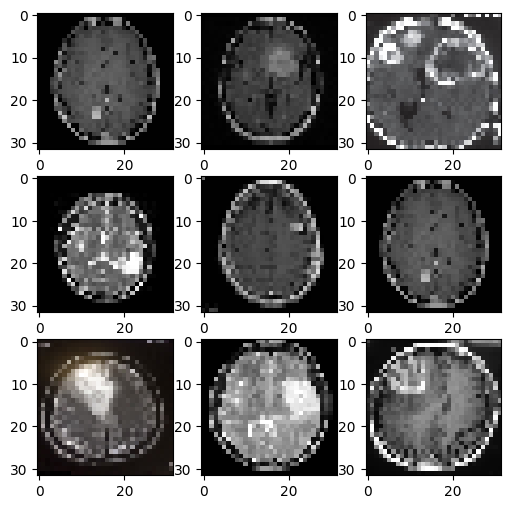

In [13]:
# Plot sample images from the dataset
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('on')

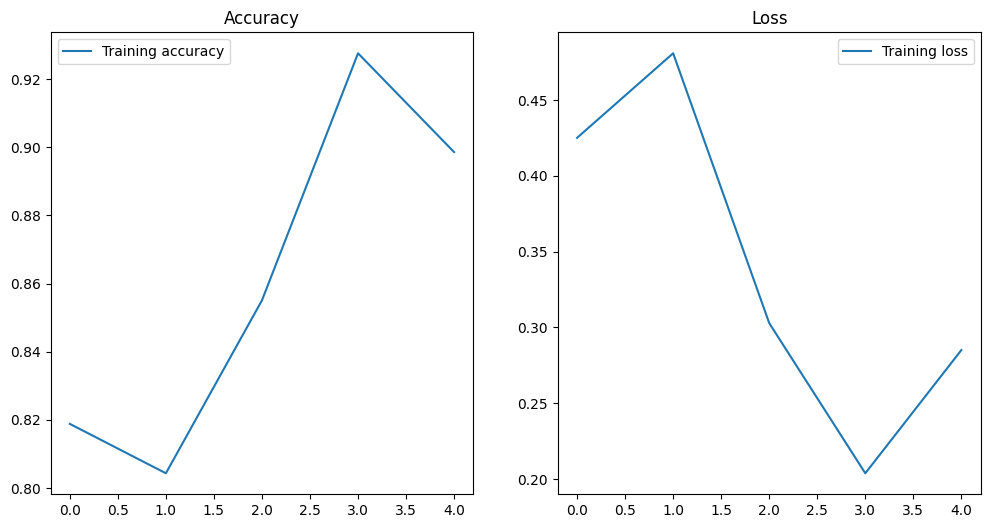

In [14]:
# Plot history of accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.legend()
plt.title('Loss')
plt.show()

2/2 [==============================] - 3s 237ms/step


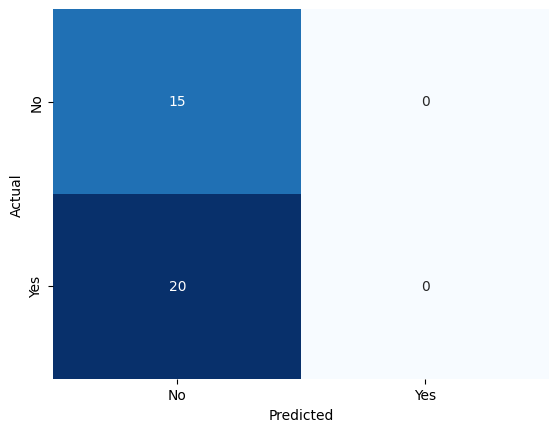

In [15]:

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


2/2 [==============================] - 3s 246ms/step


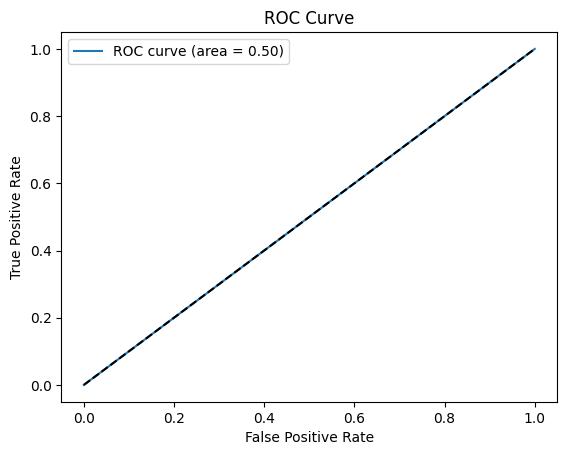

In [16]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()